In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
train_dataset=torchvision.datasets.FashionMNIST(root='./data',train=True,download=True,transform=transforms.ToTensor())

In [3]:
test_dataset=torchvision.datasets.FashionMNIST(root='./data',train=False,download=True,transform=transforms.ToTensor())

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True )

In [5]:
class encoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc11=nn.Linear(28*28,1000)
        self.fc12=nn.Linear(28*28,100)
        self.fc21=nn.Linear(1000,2000)
        self.fc22=nn.Linear(100,2000)
        self.fc31=nn.Linear(2000,10)
        self.fc32=nn.Linear(2000,10)
        self.sigm=nn.ReLU()
    def forward(self,x):
        y=self.sigm(self.fc12(x))
        y=self.sigm(self.fc22(y))
        y=self.fc32(y)
        x=self.sigm(self.fc11(x))
        x=self.sigm(self.fc21(x))
        x=self.fc31(x)
        mean=x
        stddev=y
        return mean,stddev
        

In [6]:
def sampling(x,y):
    u=torch.exp(0.5*y)
    epsilon=torch.randn_like(y)
    return x+epsilon*u

In [7]:
class decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(10,100)
        self.fc2=nn.Linear(100,400)
        self.fc3=nn.Linear(400,28*28)
        self.sigm=nn.ReLU()

    def forward(self,x,y):
        x=sampling(x,y)
        x=self.sigm(self.fc1(x))
        x=self.sigm(self.fc2(x))
        x=self.fc3(x)
        return x

In [8]:
enc1=encoder1()
dec1=decoder2()

In [9]:
enc2=encoder1()
dec2=decoder2()

In [10]:
criterion=nn.MSELoss(reduction='mean')

In [11]:
optimizer=optim.Adam(list(enc1.parameters())+list(dec1.parameters()),lr=0.001)

In [12]:
epoch=10

<strong>Used Beta annealing here with no KL divergence Loss for 1-5 epoch number. </strong>

In [13]:
for i in range(epoch):
    for x,y in train_loader:
            bthsize=len(x)
            x=x.view(bthsize,-1)
            latmean,latstd=enc1(x)
            out=dec1(latmean,latstd)
            
            KLD = -0.5 * torch.mean(1 + latstd - latmean.pow(2) - latstd.exp())
            Beta=0.005
            if i<5:
                Beta=0
            else:
                Beta=(i-5)*0.001
            reconloss=criterion(out,x)
            
            loss=reconloss+Beta*KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"epoch number{i} , recon loss is {reconloss.item()} and KLD is {KLD.item()} and total loss is {loss.item()}")
    

epoch number0 , recon loss is 0.238005593419075 and KLD is 0.0025295254308730364 and total loss is 0.238005593419075
epoch number0 , recon loss is 0.18199336528778076 and KLD is 0.16803744435310364 and total loss is 0.18199336528778076
epoch number0 , recon loss is 0.1770695596933365 and KLD is 1.293010950088501 and total loss is 0.1770695596933365
epoch number0 , recon loss is 0.14526508748531342 and KLD is 4.715888500213623 and total loss is 0.14526508748531342
epoch number0 , recon loss is 0.10657413303852081 and KLD is 2.033133029937744 and total loss is 0.10657413303852081
epoch number0 , recon loss is 0.1009158343076706 and KLD is 1.6869150400161743 and total loss is 0.1009158343076706
epoch number0 , recon loss is 0.08193676918745041 and KLD is 2.135021209716797 and total loss is 0.08193676918745041
epoch number0 , recon loss is 0.07959511131048203 and KLD is 1.9869968891143799 and total loss is 0.07959511131048203
epoch number0 , recon loss is 0.07532307505607605 and KLD is 2.2

In [25]:
subj=train_dataset[30][0]

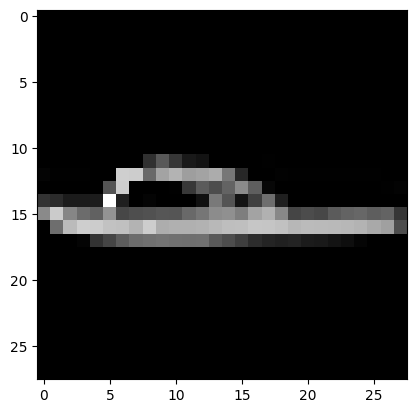

In [26]:
plt.imshow(subj.view(28,28),cmap='gray')

In [27]:

outm,outstd=enc1(subj.view(-1,28*28))

In [28]:
outm

tensor([[ 0.0745, -0.4936,  0.5910, -0.0666, -0.1687,  0.5032, -0.8633, -0.9462,
          2.3013, -0.0991]], grad_fn=<AddmmBackward0>)

In [29]:
outstd

tensor([[-3.3523, -2.9590, -2.5136, -2.3135, -3.1321, -2.1595, -2.6076, -3.7878,
         -2.5882, -2.2122]], grad_fn=<AddmmBackward0>)

In [30]:
final=dec1(outm,outstd)

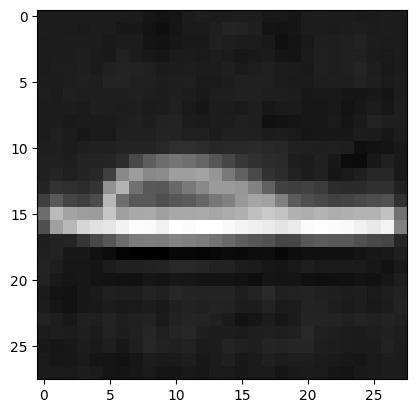

In [31]:
plt.imshow(final.view(28,28).detach(),cmap='gray')

In [33]:
torch.save(enc1,"VAEEncoder")

In [34]:
torch.save(dec1,"VAEDecoder")